In [1]:
import os

data_dir = '../datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

# 결과
# ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', 
# '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
# 420551

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


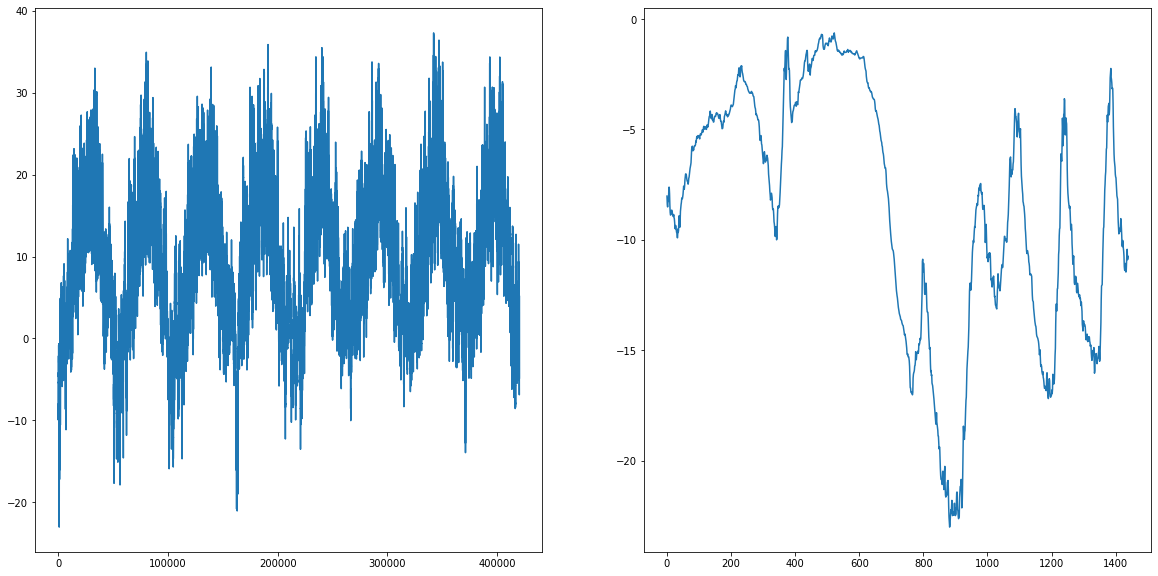

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) -1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values

# 시계열 온도 그래프 그리기    
from matplotlib import pyplot as plt

temp = float_data[:,1] # 온도(섭씨)
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(range(len(temp)), temp)

# 처음 10일간 온도 그래프 그리기
ax1 = fig.add_subplot(1, 2, 2)
plt.plot(range(1440), temp[:1440])


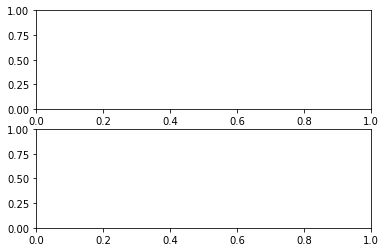

In [3]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
plt.show()

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data -= std

In [7]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while i:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size
            )
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arrange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=200001,
                      max_index=300000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

test_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=300001,
                      max_index=None,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size # 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [12]:
import tensorflow as tf

In [13]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU만 사용하도록 제한
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer = RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs=20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

C:\Users\poeun\anaconda3\envs\tf2.4\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 19s 38ms/step - loss: 10.5628 - val_loss: 3.0642
Epoch 2/20
500/500 [==============================] - 18s 37ms/step - loss: 2.9776 - val_loss: 2.5997
Epoch 3/20
500/500 [==============================] - 18s 37ms/step - loss: 2.7814 - val_loss: 2.6724
Epoch 4/20
500/500 [==============================] - 18s 36ms/step - loss: 2.7124 - val_loss: 2.5411
Epoch 5/20
500/500 [==============================] - 19s 38ms/step - loss: 2.6574 - val_loss: 2.9633
Epoch 6/20
500/500 [==============================] - 19s 38ms/step - loss: 2.6325 - val_loss: 2.6192
Epoch 7/20
500/500 [==============================] - 18s 36ms/step - loss: 2.5781 - val_loss: 2.5661
Epoch 8/20
500/500 [==============================] - 19s 37ms/step - loss: 2.5907 - val_loss: 2.5925
Epoch 9/20
500/500 [==============================] - 20s 39ms/step - loss: 2.5746 - val_loss: 2.5863
Epoch 10/20
500/500 [==============================] - 19s 38ms/step - loss: 2.55

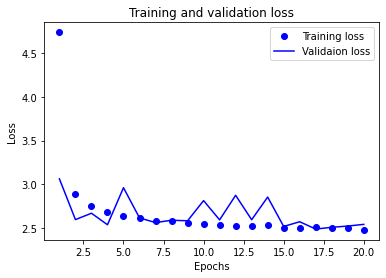

In [17]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validaion loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

C:\Users\poeun\anaconda3\envs\tf2.4\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 24s 41ms/step - loss: 5.7236 - val_loss: 2.6649
Epoch 2/20
500/500 [==============================] - 20s 39ms/step - loss: 2.8164 - val_loss: 2.4862
Epoch 3/20
500/500 [==============================] - 19s 37ms/step - loss: 2.6162 - val_loss: 2.4820
Epoch 4/20
500/500 [==============================] - 19s 38ms/step - loss: 2.5547 - val_loss: 2.4820
Epoch 5/20
500/500 [==============================] - 21s 42ms/step - loss: 2.5601 - val_loss: 2.4417
Epoch 6/20
500/500 [==============================] - 19s 39ms/step - loss: 2.4962 - val_loss: 2.4626
Epoch 7/20
500/500 [==============================] - 20s 40ms/step - loss: 2.4520 - val_loss: 2.4504
Epoch 8/20
500/500 [==============================] - 21s 42ms/step - loss: 2.4271 - val_loss: 2.4676
Epoch 9/20
500/500 [==============================] - 18s 37ms/step - loss: 2.4270 - val_loss: 2.4745
Epoch 10/20
500/500 [==============================] - 19s 38ms/step - loss: 2.392

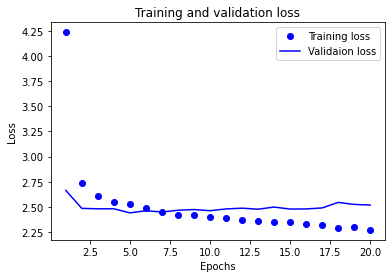

In [19]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validaion loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,    
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

C:\Users\poeun\anaconda3\envs\tf2.4\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
 41/500 [=>............................] - ETA: 21:19 - loss: 9.7866

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,    
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5,))

model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])
))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)